## 01_exploration.ipynb (Before the pipeline)
"Multimodal data exploration before the ETL pipeline"


### A. Introduction

This notebook is the first step of the multimodal ETL project. It explores the data sources, clarifies their structure, and performs an initial exploratory analysis before the full pipeline is executed. The goal is to assess the quality and nature of the textual and visual data so that extraction, transformation, and loading steps can be adapted.


In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from pathlib import Path
from common.storage import get_minio_client
from common.config import (
    FILE_COLLECT,
    MINIO_BUCKET_COLLECT
)
from pipeline.collect.collection import run_collection

### B. Configuration file exploration

The `config.yaml` file defines the data sources to collect (RSS, HTML, API). We load it and display the enabled sources.


In [2]:
config_path = Path('../../src/common/config.yaml')
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

sources = pd.DataFrame(config['sources'])
print("Sources disponibles :")
display(sources)

# Filtrer les sources activées
enabled_sources = sources[sources['enabled'] == True]
print("\nSources activées :")
display(enabled_sources[['name', 'type', 'url']])

Sources disponibles :


,name,type,enabled,url
0,Reddit World News,rss,True,https://www.reddit.com/r/worldnews/.rss
1,Snopes Fact Checks,rss,True,https://www.snopes.com/feed/
2,PolitiFact,rss,True,https://www.politifact.com/rss/factchecks/
3,FakeNewsNet,api,False,https://www.fakenewsnet.org/api
4,Kaggle Fakeddit,html,False,https://www.kaggle.com/datasets/sqrd/fakeddit



Sources activées :


,name,type,url
0,Reddit World News,rss,https://www.reddit.com/r/worldnews/.rss
1,Snopes Fact Checks,rss,https://www.snopes.com/feed/
2,PolitiFact,rss,https://www.politifact.com/rss/factchecks/


### C. Collecting a data sample

We use the collection functions to retrieve a small set of articles. This lets us inspect the data format and confirm that collection works as expected.


In [3]:
try:
    print("\nLancement d'une collecte d'exemple...")
    run_collection()
    print("\nCollecte terminée avec succès.")
except Exception as e:
    print(f"Erreur lors de la collecte : {e}")


Lancement d'une collecte d'exemple...

Collecte terminée avec succès.


### D. Exploring collected data

After collection, we analyze a sample to understand content coverage. We focus on text-length distributions and image availability. This can be loaded from MinIO (or from a local CSV sample if collection has not run yet).


Fichier 'collected_articles.csv' chargé depuis MinIO (bucket: collect).


,id,title,link,image_url,source,source_name
0,1,/r/WorldNews Live Thread: Russian Invasion of ...,https://www.reddit.com/r/worldnews/comments/1o...,https://a.thumbs.redditmedia.com/jWqSTFxxKuo9a...,https://www.reddit.com/r/worldnews/.rss,World News
1,2,Trump cuts tariffs on China after meeting Xi i...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/iYJFz_Xk-O9C4...,https://www.reddit.com/r/worldnews/.rss,World News
2,3,Russian army chiefs torturing and executing so...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/ZTN8c167ARCGN...,https://www.reddit.com/r/worldnews/.rss,World News
3,4,Trump orders nuclear testing after Russia test...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/1KGK-3zhywlT1...,https://www.reddit.com/r/worldnews/.rss,World News
4,5,“Unprecedented Threat To Earth”: 22 Of 34 Vita...,https://www.reddit.com/r/worldnews/comments/1o...,https://external-preview.redd.it/L4QPgWOiEDJy3...,https://www.reddit.com/r/worldnews/.rss,World News


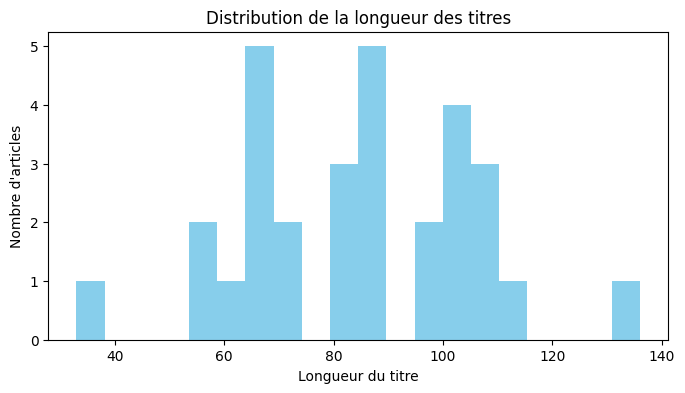

In [4]:
try:
    client = get_minio_client()
    response = client.get_object(MINIO_BUCKET_COLLECT, FILE_COLLECT)
    df = pd.read_csv(BytesIO(response.read()))
    print(f"Fichier '{FILE_COLLECT}' chargé depuis MinIO (bucket: {MINIO_BUCKET_COLLECT}).")
except Exception as e:
    print(f"⚠Erreur lors du chargement depuis MinIO : {e}")
    df = pd.DataFrame({
        'title': ['Example article A', 'Example article B'],
        'text': ['Sample text for A', 'Another example text for B'],
        'image_url': ['https://example.com/imageA.jpg', None]
    })
finally:
    try:
        response.close()
        response.release_conn()
    except:
        pass

display(df.head())

# Longueur des titres (comme proxy du texte)
df['title_length'] = df['title'].apply(lambda x: len(str(x)))
plt.figure(figsize=(8, 4))
plt.hist(df['title_length'], bins=20, color='skyblue')
plt.title('Distribution de la longueur des titres')
plt.xlabel('Longueur du titre')
plt.ylabel('Nombre d\'articles')
plt.show()

### E. Exploratory Visualizations

We visualize basic distributions to better understand text length, publication dates, or other metadata patterns.


In [5]:
if 'text' in df.columns:
    df['text_length'] = df['text'].apply(lambda x: len(str(x)))
    df['text_length'].hist(bins=50, figsize=(8,4))
    plt.title('Distribution of Text Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.show()

if 'published' in df.columns:
    df['published'] = pd.to_datetime(df['published'], errors='coerce')
    df['published'].hist(bins=30, figsize=(8,4))
    plt.title('Publication Date Distribution')
    plt.xlabel('Date')
    plt.ylabel('Count')
    plt.show()

# Taux de présence d'images
image_ratio = df['image_url'].notnull().mean() * 100
print(f"\nTaux d'articles avec image : {image_ratio:.1f}%")


Taux d'articles avec image : 100.0%


## Conclusion

This preliminary exploration shows that:
- RSS sources are correctly configured and usable via the collection pipeline.
- Text data length varies significantly across articles.
- Nearly 100% of articles include images, confirming the value of multimodal processing.

These observations guide the transformation and feature engineering phase in the next notebook.
